## Avocado Training Demo

Avocado is a multi-scale deep tensor factorization model that learns a latent representation of the human epigenome. It does so by modeling epigenomics experiments, such as those contained within the Roadmap compendium, as a tensor with three orthogonal axes---epigenomics assays (such as ChIP-seq, DNase-seq, etc), human cell types, and genomic coordinates. The model then decomposes the tensor such that each component has its own set of latent factors. These factors are jointly trained with a neural network model that combines the factors in a non-linear manner on the task of predicting epigenomic signal from the latent factors. When training is complete, one can either use latent factors and the neural network to impute epigenomic experiments that have not yet been performed, or use the learned latent factors by themselves for downstream genomics analyses in the place of epigenomic data itself. The following schematic describes the model.

<img src="figures/Avocado-Schematic.png" style="width:66%">

This tutorial will demonstrate how someone can use the provided Avocado code-base in order to train their own models on their own sets of data. The full Avocado model utilized a cluster of GPUs for many hours to perform training, and so we will focus on a scaled-down version of the model restricted to the ENCODE Pilot Regions. Should a user be running this tutorial on a machine that has a GPU, uncomment the following lines in order to enable GPU acceleration. By default it will use the first cuda enabled device, but by changing the number after `cuda` one can specify any GPU.

In [1]:
#import os, sys   
#os.environ['THEANO_FLAGS'] = "device=cuda0" 

Before beginning, let's output the package versions and computer specifics that this tutorial was run with.

In [2]:
%load_ext watermark
%watermark -n -m -p numpy,pandas,keras,theano,sklearn,joblib,tqdm,xgboost,matplotlib,seaborn

/home/jmschr/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Fri Oct 05 2018 

numpy 1.14.2
pandas 0.23.4
keras 2.1.6
theano 1.0.1
sklearn 0.20.0
joblib 0.12.4
tqdm 4.24.0
xgboost 0.7.post3
matplotlib 2.1.0
seaborn 0.8.0

compiler   : GCC 7.2.0
system     : Linux
release    : 4.15.0-34-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


Now let's load up some basic utility modules and plotting libraries that we'll use.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set_style('whitegrid')
import itertools
import numpy; numpy.random.seed(0)

When using the Avocado code-base, one needs only load the Avocado model from the `model` file.

In [4]:
from avocado import Avocado

The Avocado model is a thin wrapper over a keras defined model that is fairly simple to define. Here is the script that builds the model internally.

In [5]:
def build_model(n_celltypes, n_celltype_factors, n_assays, n_assay_factors,
    n_genomic_positions, n_25bp_factors, n_250bp_factors, n_5kbp_factors,
    n_layers, n_nodes, freeze_celltypes=False, freeze_assays=False,
    freeze_genome_25bp=False, freeze_genome_250bp=False, 
    freeze_genome_5kbp=False, freeze_network=False):
    """This function builds a multi-scale deep tensor factorization model."""

    celltype_input = Input(shape=(1,), name="celltype_input")
    celltype_embedding = Embedding(n_celltypes, n_celltype_factors, 
        input_length=1, name="celltype_embedding")
    celltype_embedding.trainable = not freeze_celltypes
    celltype = Flatten()(celltype_embedding(celltype_input))

    assay_input = Input(shape=(1,), name="assay_input")
    assay_embedding = Embedding(n_assays, n_assay_factors, 
        input_length=1, name="assay_embedding")
    assay_embedding.trainable = not freeze_assays
    assay = Flatten()(assay_embedding(assay_input))

    genome_25bp_input = Input(shape=(1,), name="genome_25bp_input")
    genome_25bp_embedding = Embedding(n_genomic_positions, n_25bp_factors, 
        input_length=1, name="genome_25bp_embedding")
    genome_25bp_embedding.trainable = not freeze_genome_25bp
    genome_25bp = Flatten()(genome_25bp_embedding(genome_25bp_input))

    genome_250bp_input = Input(shape=(1,), name="genome_250bp_input")
    genome_250bp_embedding = Embedding((n_genomic_positions / 10) + 1,
        n_250bp_factors, input_length=1, name="genome_250bp_embedding")
    genome_250bp_embedding.trainable = not freeze_genome_250bp
    genome_250bp = Flatten()(genome_250bp_embedding(genome_250bp_input))

    genome_5kbp_input = Input(shape=(1,), name="genome_5kbp_input")
    genome_5kbp_embedding = Embedding((n_genomic_positions / 200) + 1, 
        n_5kbp_factors, input_length=1, name="genome_5kbp_embedding")
    genome_5kbp_embedding.trainable = not freeze_genome_5kbp
    genome_5kbp = Flatten()(genome_5kbp_embedding(genome_5kbp_input))

    layers = [celltype, assay, genome_25bp, genome_250bp, genome_5kbp]
    inputs = (celltype_input, assay_input, genome_25bp_input, 
        genome_250bp_input, genome_5kbp_input)

    x = concatenate(layers)
    for i in range(n_layers):
        layer = Dense(n_nodes, activation='relu', name="dense_{}".format(i))
        layer.trainable = not freeze_network
        x = layer(x)

    layer = Dense(1, name="y_pred")
    layer.trainable = not freeze_network
    y = layer(x)

    model = Model(inputs=inputs, outputs=y)
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return model


The majority of lines correspond to setting up the inputs appropriately since we're using embedding layers as the tensor factorization component.

### Training the model

Now we're ready to go! The first thing we need to do is define the cell type and assay dimensions. We give the names of the cell types and assays that we want to model and require that each cell type has at least one assay in the training set and that each assay has been performed in at least one cell type in the training set.

In [6]:
celltypes = ['E003', 'E017', 'E065', 'E116', 'E117']
assays = ['H3K4me3', 'H3K27me3', 'H3K36me3', 'H3K9me3', 'H3K4me1']

Next, we need to create the data structure that we used to feed the training data into the model. We use a dictionary, `data`, where the keys are a tuple of `(celltype, assay)` and the value is a numpy array that contains the signal values from that epigenomic experiment. These values are assumed to be at 25 bp resolution, though any resolution can be modeled as long as the user is okay with one set of factors being learned at 1/10th the resolution (normally the 250 bp factors) and another set being learned at 1/200th the resolution (normally the 5 kbp factors). We found that the best way to encode these tracks is in a compressed numpy array (ending in .npz) that can be unpacked using `numpy.load(X)['arr_0']` instead of just `numpy.load(X)`. If the user is using uncompressed files (ending in .npy) they should use `numpy.load(X)`.

Our example data contains five assays that have been performed in five cell types, for a total of 25 epigenomic experiments. We will train our model on 24 and see how well it can impute the held out experiment, H3K4me3 signal from E065 (Aorta).

In [7]:
data = {}
for celltype, assay in itertools.product(celltypes, assays):
    if celltype == 'E065' and assay == 'H3K4me3':
        continue
        
    filename = 'data/{}.{}.pilot.arcsinh.npz'.format(celltype, assay)
    data[(celltype, assay)] = numpy.load(filename)['arr_0']

Now we need to build our model. Let's first look at the arguments that we can pass in.

In [8]:
help(Avocado)

Help on class Avocado in module avocado.model:

class Avocado(__builtin__.object)
 |  An Avocado multi-scale deep tensor factorization model.
 |  
 |  The Avocado model is a multi-scale deep tensor factorization model. It is
 |  multi-scale because it represents the genome axis using three different
 |  resolutions---25 bp, 250 bp and 5 kbp. It is deep because it replaces the
 |  dot product component of most linear factorization approaches with a deep
 |  neural network. The tensor factors and the neural network weights are
 |  trained jointly to impute the values in the tensor that it is provided.
 |  
 |  In this case Avocado is trained on epigenomic data whose dimensions are
 |  human cell type, epigenomic assay, and genomic coordinate. The trained
 |  model can impute epigenomic assays that have not yet been performed, and
 |  the learned factor values can themselves be used to represent genomic
 |  positions more compactly than the full set of epigenomic measurements
 |  could.
 

The default parameters are the ones that are used in the manuscript. Since we are using a scaled down version, we will use significantly fewer parameters so that a model can be trained on a modest laptop.

In [9]:
model = Avocado(celltypes, assays, n_layers=1, n_nodes=128, n_assay_factors=24, n_celltype_factors=32,
        n_25bp_factors=10, n_250bp_factors=20, n_5kbp_factors=30, batch_size=10000)

Let's take a look at a summary of the layers in the model.

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
celltype_input (InputLayer)     (None, 1)            0                                            
__________________________________________________________________________________________________
assay_input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
genome_25bp_input (InputLayer)  (None, 1)            0                                            
__________________________________________________________________________________________________
genome_250bp_input (InputLayer) (None, 1)            0                                            
__________________________________________________________________________________________________
genome_5kb

Now, all we need to do to train the model is to run the `fit` method.

In [11]:
help(model.fit)

Help on method fit in module avocado.model:

fit(self, X_train, X_valid=None, n_epochs=200, epoch_size=120, verbose=1, callbacks=None, **kwargs) method of avocado.model.Avocado instance
    Fit the model to the given epigenomic tracks.
    
    Pass in a dictionary of training data and an optional dictionary of
    validation data. The keys to this dictionary are a tuple of the format
    (celltype, assay) and the values are the corresponding track in the
    form of a numpy array. The tracks can either be in the form of an array
    that is in memory or as a memory map.
    
    Parameters
    ----------
    X_train : dict
            A dictionary of training data values, where the keys are a tuple of
            (celltype, assay) and the values are a track.
    
    X_valid : dict or None, optional
            A dictionary of validation data values that are used to calculate
            validation set MSE during the training process. If None, validation
            set statistics are

Let's now run training for one epoch. The default training scheme involves sequentially going through all positions in the given genomic region, seeing batch_size * epoch_size positions before saying that the epoch is complete. If one wants to match one epoch with one pass of the genome, they should balance batch_size and epoch_size such that they are roughly equal to n_genomic_positions. Since we are training on the ENCODE Pilot Regions, which have 1,126,469 positions, and we set batch_size to 10,000, we will set epoch_size to 113.

In [12]:
model.fit(data, n_epochs=1, epoch_size=113)

avocado/model.py:438: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., 113, 1, callbacks=None, workers=1, verbose=1, use_multiprocessing=True)`
  callbacks=callbacks, **kwargs)


Epoch 1/1
113/113 [==============================] - 19s 168ms/step - loss: 0.2417 - mean_squared_error: 0.2417


We've now scanned through the genome approximately once. This means that each 25 bp factor has seen exactly one training sample, the 250 bp factors have each seen 10, the 5 kbp factors 200. The cell type factors, assay factors, and neural network have each seen ~1.2 million samples.

Let's now make a prediction. We can do that using the `predict` function, where we pass in the cell type and assay that we want to predict.

In [13]:
y_hat  = model.predict("E065", "H3K4me3")

We can then visually inspect this imputation and compare the MSE of the imputation to that of imputing the average signal value of the track.

In [14]:
y_true = numpy.load("data/E003.H3K4me3.pilot.arcsinh.npz")['arr_0']

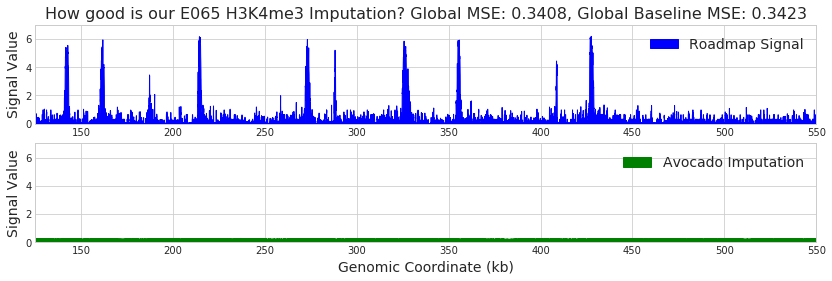

In [15]:
start, end = 5000, 22000
x = numpy.arange(start*25/1000., end*25/1000., 25/1000.)

mse_global = ((y_hat - y_true) ** 2).mean()
baseline_mse = ((y_true - y_true.mean()) ** 2).mean()

plt.figure(figsize=(14, 4))
plt.subplot(211)
plt.title("How good is our E065 H3K4me3 Imputation? Global MSE: {:4.4}, Global Baseline MSE: {:4.4}".format(mse_global, baseline_mse), fontsize=16)
plt.fill_between(x, 0, y_true[start:end], color='b', label="Roadmap Signal")
plt.legend(fontsize=14)
plt.ylabel("Signal Value", fontsize=14)
plt.ylim(0, 7)
plt.xlim(start*25/1000., end*25/1000.)

plt.subplot(212)
plt.fill_between(x, 0, y_hat[start:end], color='g', label="Avocado Imputation")
plt.legend(fontsize=14)
plt.ylabel("Signal Value", fontsize=14)
plt.xlabel("Genomic Coordinate (kb)", fontsize=14)
plt.ylim(0, 7)
plt.xlim(start*25/1000., end*25/1000.)
plt.show()

It looks like after one round the model has mostly learned to predict low signal everywhere. What happens if we let the model train for another epoch? Let's also focus on two of the peaks in order to see the behavior of the model better.

In [16]:
model.fit(data, n_epochs=1, epoch_size=113)

Epoch 1/1
113/113 [==============================] - 19s 164ms/step - loss: 0.2312 - mean_squared_error: 0.2312


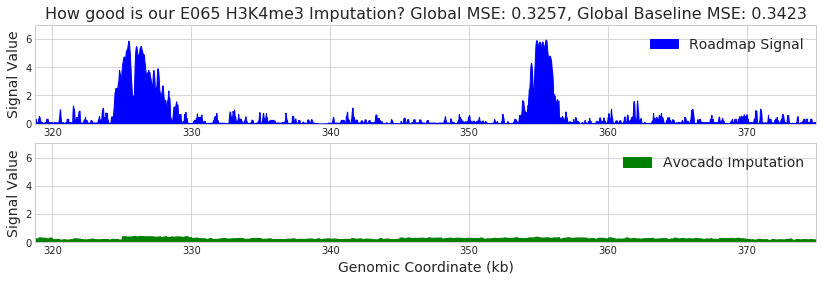

In [17]:
y_hat  = model.predict("E065", "H3K4me3") # Make new predictions

start, end = 12750, 15000
x = numpy.arange(start*25/1000., end*25/1000., 25/1000.)

mse_global = ((y_hat - y_true) ** 2).mean()
baseline_mse = ((y_true - y_true.mean()) ** 2).mean()

plt.figure(figsize=(14, 4))
plt.subplot(211)
plt.title("How good is our E065 H3K4me3 Imputation? Global MSE: {:4.4}, Global Baseline MSE: {:4.4}".format(mse_global, baseline_mse), fontsize=16)
plt.fill_between(x, 0, y_true[start:end], color='b', label="Roadmap Signal")
plt.legend(fontsize=14)
plt.ylabel("Signal Value", fontsize=14)
plt.ylim(0, 7)
plt.xlim(start*25/1000., end*25/1000.)

plt.subplot(212)
plt.fill_between(x, 0, y_hat[start:end], color='g', label="Avocado Imputation")
plt.legend(fontsize=14)
plt.ylabel("Signal Value", fontsize=14)
plt.xlabel("Genomic Coordinate (kb)", fontsize=14)
plt.ylim(0, 7)
plt.xlim(start*25/1000., end*25/1000.)
plt.show()

Looks like after the second epoch we're able to see some blocks of imputed signal raise up. This makes sense, because the lower resolution factors are likely to train faster since they see more samples per epoch. However, the peaks in the imputed signal don't quite match those in the real data quite yet.

Let's jump ahead 3 more epochs.

In [18]:
model.fit(data, n_epochs=3, epoch_size=113)

avocado/model.py:438: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., 113, 3, callbacks=None, workers=1, verbose=1, use_multiprocessing=True)`
  callbacks=callbacks, **kwargs)


Epoch 1/3
113/113 [==============================] - 18s 160ms/step - loss: 0.2232 - mean_squared_error: 0.2232
Epoch 2/3
113/113 [==============================] - 20s 176ms/step - loss: 0.2139 - mean_squared_error: 0.2139
Epoch 3/3
113/113 [==============================] - 18s 157ms/step - loss: 0.2013 - mean_squared_error: 0.2013


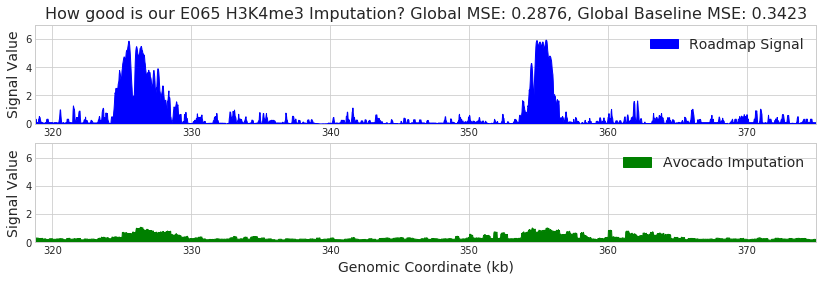

In [19]:
y_hat  = model.predict("E065", "H3K4me3") # Make new predictions

start, end = 12750, 15000
x = numpy.arange(start*25/1000., end*25/1000., 25/1000.)

mse_global = ((y_hat - y_true) ** 2).mean()
baseline_mse = ((y_true - y_true.mean()) ** 2).mean()

plt.figure(figsize=(14, 4))
plt.subplot(211)
plt.title("How good is our E065 H3K4me3 Imputation? Global MSE: {:4.4}, Global Baseline MSE: {:4.4}".format(mse_global, baseline_mse), fontsize=16)
plt.fill_between(x, 0, y_true[start:end], color='b', label="Roadmap Signal")
plt.legend(fontsize=14)
plt.ylabel("Signal Value", fontsize=14)
plt.ylim(0, 7)
plt.xlim(start*25/1000., end*25/1000.)

plt.subplot(212)
plt.fill_between(x, 0, y_hat[start:end], color='g', label="Avocado Imputation")
plt.legend(fontsize=14)
plt.ylabel("Signal Value", fontsize=14)
plt.xlabel("Genomic Coordinate (kb)", fontsize=14)
plt.ylim(0, 7)
plt.xlim(start*25/1000., end*25/1000.)
plt.show()

More defined peaks that seem better centered around the real peaks. Let's jump forward another 5 epochs and see what happens.

In [20]:
model.fit(data, n_epochs=5, epoch_size=113)

avocado/model.py:438: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., 113, 5, callbacks=None, workers=1, verbose=1, use_multiprocessing=True)`
  callbacks=callbacks, **kwargs)


Epoch 1/5
113/113 [==============================] - 21s 181ms/step - loss: 0.1905 - mean_squared_error: 0.1905
Epoch 2/5
113/113 [==============================] - 19s 167ms/step - loss: 0.1744 - mean_squared_error: 0.1744
Epoch 3/5
113/113 [==============================] - 18s 161ms/step - loss: 0.1588 - mean_squared_error: 0.1588
Epoch 4/5
113/113 [==============================] - 17s 154ms/step - loss: 0.1500 - mean_squared_error: 0.1500
Epoch 5/5
113/113 [==============================] - 18s 155ms/step - loss: 0.1443 - mean_squared_error: 0.1443


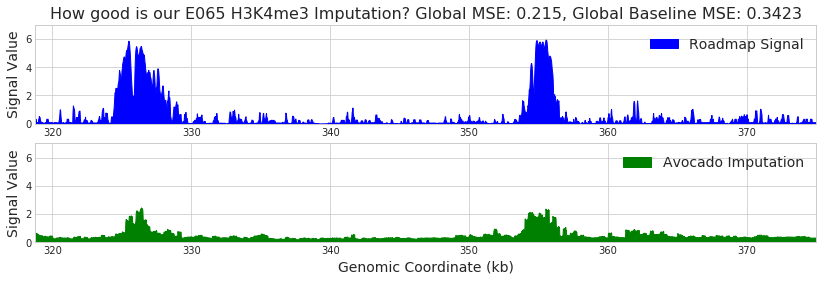

In [21]:
y_hat  = model.predict("E065", "H3K4me3") # Make new predictions

start, end = 12750, 15000
x = numpy.arange(start*25/1000., end*25/1000., 25/1000.)

mse_global = ((y_hat - y_true) ** 2).mean()
baseline_mse = ((y_true - y_true.mean()) ** 2).mean()

plt.figure(figsize=(14, 4))
plt.subplot(211)
plt.title("How good is our E065 H3K4me3 Imputation? Global MSE: {:4.4}, Global Baseline MSE: {:4.4}".format(mse_global, baseline_mse), fontsize=16)
plt.fill_between(x, 0, y_true[start:end], color='b', label="Roadmap Signal")
plt.legend(fontsize=14)
plt.ylabel("Signal Value", fontsize=14)
plt.ylim(0, 7)
plt.xlim(start*25/1000., end*25/1000.)

plt.subplot(212)
plt.fill_between(x, 0, y_hat[start:end], color='g', label="Avocado Imputation")
plt.legend(fontsize=14)
plt.ylabel("Signal Value", fontsize=14)
plt.xlabel("Genomic Coordinate (kb)", fontsize=14)
plt.ylim(0, 7)
plt.xlim(start*25/1000., end*25/1000.)
plt.show()

It looks like now we're starting to impute peaks at the correct positions. In fact, in the peak on the left we're seeing a little valley between the two imputed mini-peaks, just like in the data.

When you're done training the model, you can save it easily. Saving a file produces a json file that describes the structure and a h5 file that stores the weights.

In [22]:
model.save("test-model")

The model can then be loaded up later.

In [23]:
model = Avocado.load("test-model")

### Adding additional cell types to a model

It may be the case that your favorite cell type or assay is not a part of the pre-trained model. In this case, it is easy to add a new cell type or assay to the pre-trained embeddings. This process essentially freezes the remainder of the model, including the other cell type or assay embeddings, and learns the new embeddings by themselves, and then returns a new model whose cell type or assay embedding contains the pretrained embeddings followed by the newly trained ones.

If you want to add a new cell type to the model you need to first create a data dictionary of the same format as before except that the cell types are not currently a part of the model. All of the assays must be a part of the model, though. Let's use the data from E003 but pretend that it's E004 for the purpose of this example.

In [24]:
data = {}
for assay in assays:
    filename = 'data/E003.{}.pilot.arcsinh.npz'.format(assay)
    data[('E004', assay)] = numpy.load(filename)['arr_0']

Now we just need to call the `model.fit_celltypes` method, with the same calls as the normal `fit` method.

In [25]:
model.fit_celltypes(data, n_epochs=5)

avocado/model.py:584: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., 120, 5, callbacks=None, workers=1, verbose=1, use_multiprocessing=True)`
  callbacks=callbacks, **kwargs)


Epoch 1/5
120/120 [==============================] - 6s 54ms/step - loss: 0.1824 - mean_squared_error: 0.1824
Epoch 2/5
120/120 [==============================] - 6s 53ms/step - loss: 0.1695 - mean_squared_error: 0.1695
Epoch 3/5
120/120 [==============================] - 7s 56ms/step - loss: 0.1767 - mean_squared_error: 0.1767
Epoch 4/5
120/120 [==============================] - 8s 70ms/step - loss: 0.1829 - mean_squared_error: 0.1829
Epoch 5/5
120/120 [==============================] - 7s 57ms/step - loss: 0.1674 - mean_squared_error: 0.1674


In [26]:
model.celltypes

[u'E003', u'E017', u'E065', u'E116', u'E117', 'E004']

We can see that the "E004" has been added to the list of cell types stores in the model. Let's see whether it's embedding is similar to that of E003.

In [27]:
numpy.abs(model.celltype_embedding[-1] - model.celltype_embedding).sum(axis=1)

array([0.83619946, 1.890521  , 3.2636106 , 2.4219823 , 3.017827  ,
       0.        ], dtype=float32)

Our learned embedding isn't exactly the same as E003, likely because neither the original model nor the new embedding are fully trained on the data.

If you want to add an assay to the embedding you can do the same thing except with a call to `fit_assays`, ensuring that all cell types in the data dictionary are already present but that none of the assays in that dictionary are.

### Extracting latent representations

After training the model we can now extract the latent representations from the model. There are built in functions that allow you to extract the layer named "celltype_embedding", the layer named "assay_embedding", and build the genome embedding from the three scales of genomic embeddings provided.

In [28]:
model.celltype_embedding.shape

(6, 32)

In [29]:
model.assay_embedding.shape

(5, 24)

In [30]:
genome_embedding = model.genome_embedding
genome_embedding.shape

(1126469, 60)

The genome embedding is comprised first of columns from the 25 bp embedding, then of columns from the 250 bp embedding, and lastly of columns from the 5 kbp embedding. Each row corresponds to the representation from one 25 bp position, and so the value in the 250 bp representation is repeated 10 times in a row, and the value in the 5 kbp representation is repeated 200 times in a row.

In order to see what that looks like, let's visualize the resulting matrix.

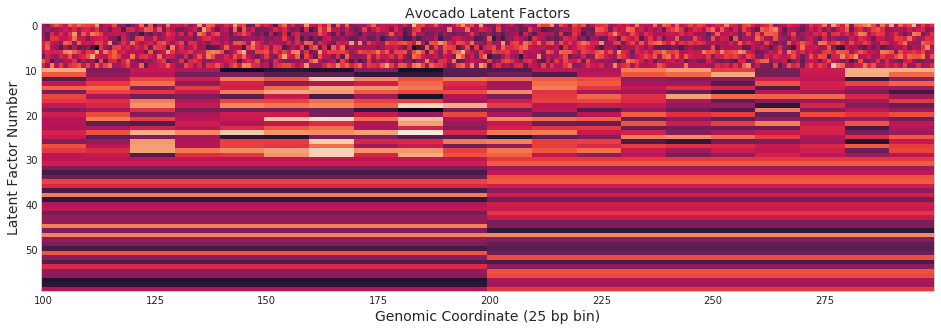

In [31]:
plt.figure(figsize=(16, 10))
plt.title("Avocado Latent Factors", fontsize=14)
plt.imshow(genome_embedding[100:300].T)
plt.ylabel("Latent Factor Number", fontsize=14)
plt.yticks(fontsize=10)
plt.xlabel("Genomic Coordinate (25 bp bin)", fontsize=14)
plt.xticks(range(0, 200, 25), range(100, 300, 25), fontsize=10)
plt.grid(False)


When we consider this visualization of genomic positions 2500 to 7500, the three scales of latent factors become immediately obvious. There are some factors that differ from one coordinate to the next, the 25 bp factors, some that are the same for 10 consecutive positions, the 250 bp factors, and some that are the same for 200 consecutive positions, the 5 kbp factors. In this case the 5 kbp factors would span from 0 to 200 and then 200 to 400, but we focus on 100 to 300 for display purposes. 